## Exercise 1

Poisson regression is a Generalized Linear Model, used to model count data. It takes the form

$$\mathbb{E}(\mu|x)=\exp(w_1\,x_1+\ldots+w_k\,x_k+b),$$

where the observed counts $y$ are drawn from a Poisson distribution on the expected counts: 

$$y_i \sim \text{Poisson}(\mu_i).$$

1. Download and import Load the smoking dataset from: [https://data.princeton.edu/wws509/datasets/#smoking](https://data.princeton.edu/wws509/datasets/#smoking). Then perform a train-test split on the data;
2. Fit a Poisson bayesian regression model using the number of deaths as the response variable and the other columns as the explanatory variables;
3. Evaluate the regression fit on test data using MAE and MSE error metrics.

### Solution

Let's begin by taking a look at the raw data:

In [1]:
#import required libraries
import pyro
import torch
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
import pandas as pd 
import numpy as np
from pyro.infer import Predictive
import torch.distributions.constraints as constraints
import matplotlib.pyplot as plt

In [2]:
# load data from csv and remove NA values
data = pd.read_table('data/smoking.raw', names=["AgeGroup","SmokingHabits","TotalCount","DeadAfter6Years"])

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   AgeGroup         36 non-null     int64
 1   SmokingHabits    36 non-null     int64
 2   TotalCount       36 non-null     int64
 3   DeadAfter6Years  36 non-null     int64
dtypes: int64(4)
memory usage: 1.2 KB
None


,AgeGroup,SmokingHabits,TotalCount,DeadAfter6Years
0,1,1,656,18
1,2,1,359,22
2,3,1,249,19
3,4,1,632,55
4,5,1,1067,117


The dataset description available at the link reports that:
- `AgeGroup` is the index of the corresponding population group age range, going from 40-44 to 80+ in steps of 5 years
- `SmokingHabits` codes whether the subjects group smoked cigarettes and/or pipes and cigars during the 6 years duration of the study, more specifically:
    - 1 = didn't smoke either
    - 2 = only smoked pipes and cigars
    - 3 = smoked both cigarettes and pipes and cigars
    - 4 = only smoked cigarettes

We will use a one-hot encoding to represent the age ranges and two binary variables to represent the smoking habits (one flag for cigarettes and one for pipes and cigars).

Furthermore we will apply a simple linear scaling of factor 1000 to the group population count just to avoid exploding exponentiation.  
As suggested in the exercise text we will attempt to fit the death count $y_i$ for the groups by modeling this quantity with a Poisson distribution whose mean (and variance) $\mu_i$ depends on the other covariates. 
Furthermore we'll assume a standard normal prior distribution for the weights and a LogNormal prior for the bias $b$ appearing in the linear combination.  
Here's the model:

$$y_i \sim \text{Poisson}(\mu_i)\\
\mu_i =\exp( w \cdot x_i + b)\\
w \sim \mathcal{N}(\textbf{0},\textbf{1})\\
b \sim \text{LogNormal}(0,1)
$$

where $x_i$ is the vector of covariates comprising
- the one hot representation of `AgeGroup` (9 dimensions)
- the twin binary representation of `SmokingHabits` (2 dimensions)
- the rescaled number of deaths (1 dimension)

First we'll reformat the raw dataset to comply with the data model just outlined:

In [3]:
# re-elaborate cathegorical covariates 
data["SmokedCigarettes"] = data.apply(lambda row: float(row["SmokingHabits"] > 2), axis=1)
data["SmokedCigarOrPipe"] = data.apply(lambda row: float(row["SmokingHabits"] == 2 or row["SmokingHabits"] == 3), axis=1)

#data["AvgAge"] = data.apply(lambda row: 42.5 + (row["AgeGroup"]-1) * 5, axis=1)
agesonehot = pd.get_dummies(data['AgeGroup'], prefix = 'Age')
data["RescaledCount"] = data["TotalCount"] / 1000
df1 = pd.concat([agesonehot, data[["SmokedCigarettes", "SmokedCigarOrPipe", "RescaledCount", "DeadAfter6Years"]] ], axis=1)

print(df1.info())
df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age_1              36 non-null     uint8  
 1   Age_2              36 non-null     uint8  
 2   Age_3              36 non-null     uint8  
 3   Age_4              36 non-null     uint8  
 4   Age_5              36 non-null     uint8  
 5   Age_6              36 non-null     uint8  
 6   Age_7              36 non-null     uint8  
 7   Age_8              36 non-null     uint8  
 8   Age_9              36 non-null     uint8  
 9   SmokedCigarettes   36 non-null     float64
 10  SmokedCigarOrPipe  36 non-null     float64
 11  RescaledCount      36 non-null     float64
 12  DeadAfter6Years    36 non-null     int64  
dtypes: float64(3), int64(1), uint8(9)
memory usage: 1.6 KB
None


,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,SmokedCigarettes,SmokedCigarOrPipe,RescaledCount,DeadAfter6Years
0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.656,18
1,0,1,0,0,0,0,0,0,0,0.0,0.0,0.359,22
2,0,0,1,0,0,0,0,0,0,0.0,0.0,0.249,19
3,0,0,0,1,0,0,0,0,0,0.0,0.0,0.632,55
4,0,0,0,0,1,0,0,0,0,0.0,0.0,1.067,117


We'll now perform a randomised 80/20 train-test split on the data. Randomisation will ensure that all the groups are equally likely to be represented in the final datasets.

In [4]:
# convert df to tensors
y = torch.tensor(df1["DeadAfter6Years"].values, dtype=torch.float)
x = torch.tensor(df1.loc[:,df1.columns!="DeadAfter6Years"].values, dtype=torch.float)

# perform train-test 80-20 random split
np.random.seed(7)
indices = np.random.permutation(x.shape[0])
test_idx = int(len(indices)*.8)
x_train, x_test = x[indices[:test_idx]], x[indices[test_idx:]]
y_train, y_test = y[indices[:test_idx]], y[indices[test_idx:]]

#check shapes
print("x_train.shape =", x_train.shape,"\ny_train.shape =", y_train.shape)
print("\nx_test.shape =", x_test.shape,"\ny_test.shape =", y_test.shape)

x_train.shape = torch.Size([28, 12]) 
y_train.shape = torch.Size([28])

x_test.shape = torch.Size([8, 12]) 
y_test.shape = torch.Size([8])


We thus proceed in defining the SVI model and training it

In [5]:
# define poisson model and guide
def model_pois(x,y):
    
    # training samples
    n, d = x.shape
    
    # parameters
    w = pyro.sample("w", dist.Normal(torch.zeros(d), 
                                        torch.ones(d)))
    b = pyro.sample("b", dist.LogNormal(torch.zeros(1), torch.ones(1)))
    
    mu = ((w*x).sum(dim=1) + b).exp()
    
    
    # condition on the observations
    with pyro.plate("ys", len(y)):
        pyro.sample("y", dist.Poisson(mu), obs=y)

def model_guide(x,y):
    n, d = x.shape
        
    w_mean = pyro.param("w_mean", torch.rand(d))
    w_stdev = pyro.param("w_stdev", torch.rand(d), constraint=constraints.positive)
    
    w = pyro.sample("w", dist.Normal(w_mean, w_stdev))
    
    b_mean = pyro.param("b_mean", torch.rand(1))
    b_stdev = pyro.param("b_stdev", torch.rand(1), constraint=constraints.positive)
    
    b = pyro.sample("b", dist.LogNormal(b_mean, b_stdev))

#SVI model
smoke_svi = SVI(model=model_pois,
                guide=model_guide,
                optim=optim.ClippedAdam({'lr' : 0.01}),
                loss=Trace_ELBO()) 

Step 0 : loss = 1025.5805416873523
Step 100 : loss = 260.83801232916966
Step 200 : loss = 86.80966620998723
Step 300 : loss = 157.37800325240408
Step 400 : loss = 101.70314640871116
Step 500 : loss = 43.96210683030741
Step 600 : loss = 25.83638764492103
Step 700 : loss = 22.08130862031664
Step 800 : loss = 16.239721970898763
Step 900 : loss = 16.425975292921066
Step 1000 : loss = 14.751621774264745
Step 1100 : loss = 14.780064599854606
Step 1200 : loss = 14.827269630772728
Step 1300 : loss = 14.71488881111145
Step 1400 : loss = 15.376533278397151
Step 1500 : loss = 14.936981669494084
Step 1600 : loss = 14.903554320335388
Step 1700 : loss = 14.794646356787
Step 1800 : loss = 15.136690284524645
Step 1900 : loss = 14.705123594829015


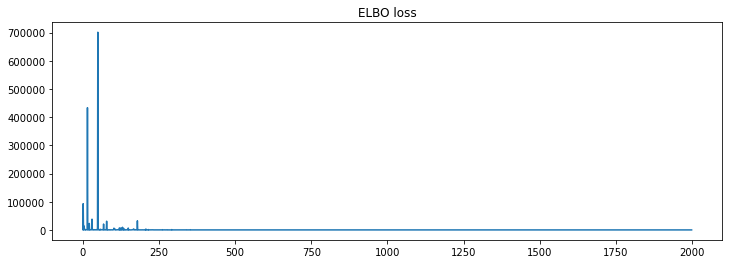

In [6]:
# do the training
pyro.set_rng_seed(0)
pyro.clear_param_store()
lossplot = []
for step in range(2000):
    loss = smoke_svi.step(x_train, y_train)/len(x_train)
    lossplot.append(loss)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(lossplot)
ax.set_title("ELBO loss");

Finally let's check the performance of our model by estimating MSE and MAE

In [7]:
# retrieve the fitted parameters
print("Inferred params:", list(pyro.get_param_store().keys()), end="\n\n")

inferred_w = pyro.get_param_store()["w_mean"]
inferred_b = pyro.get_param_store()["b_mean"]

for i,w in enumerate(inferred_w):
    print(f"w_{i} = {w.item():.8f}")
print(f"b = {inferred_b.item():.8f}")

# compute predictions using the inferred paramters
y_pred = ((inferred_w * x_test).sum(1) + inferred_b).exp()

print("MAE =", torch.nn.L1Loss()(y_test, y_pred).item())
print("MSE =", torch.nn.MSELoss()(y_test, y_pred).item())
print("Standard deviation of targets =", y_test.std().item())

Inferred params: ['w_mean', 'w_stdev', 'b_mean', 'b_stdev']

w_0 = -0.27605838
w_1 = -0.60292614
w_2 = 0.61951894
w_3 = 1.10528374
w_4 = 1.28495550
w_5 = 1.80718970
w_6 = 1.95685613
w_7 = 2.30396509
w_8 = 1.52485478
w_9 = 0.63892394
w_10 = -0.18967140
w_11 = 0.36394951
b = 1.14986229
MAE = 213.81732177734375
MSE = 94935.6953125
Standard deviation of targets = 273.4932556152344


Even if we haven't got other references (yet) we could tell that the errors seems pretty high and suggest that the model fit isn't very good. Intuitively we can see that the MAE is not far from the targets' standard deviation (also printed in the previous output), meaning that the average prediction error is close to the variability of the outputs.  
Yet this could in no way be considered a satisfactory explanation to our claim that the model's fit isn't very good, therefore we'll now attempt to find a more "practical" demonstration, that is, by fitting a slightly different model and see if we can improve on our previous results.

This time we will ignore the total count and try to fit the death rate instead, modeling it with a Beta distribution whose parameters will depend on the predictors that specify the group characteristics, that is:

$$ y_i \sim \text{Beta}(\alpha_i,\beta_i)\\
\alpha_i = \exp(w_\alpha \cdot x_i + b_\alpha)\\
\beta_i = \exp(w_\beta \cdot x_i + b_\beta)\\
w_\alpha, w_\beta \sim \mathcal{N}(0,1) \\
b_\alpha, b_\beta \sim \text{LogNormal}(0,1)
$$

Once again we start by populating our data model and performing the train/test split, we will then proceed in defining the SVI model, training it and evaluating the final metrics.

In [8]:
data["DeathRatioAfter6Years"] = data["DeadAfter6Years"] / data["TotalCount"]
df2 = pd.concat([agesonehot, data[["SmokedCigarettes", "SmokedCigarOrPipe", "DeathRatioAfter6Years"]] ], axis=1)


print(df2.info())
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age_1                  36 non-null     uint8  
 1   Age_2                  36 non-null     uint8  
 2   Age_3                  36 non-null     uint8  
 3   Age_4                  36 non-null     uint8  
 4   Age_5                  36 non-null     uint8  
 5   Age_6                  36 non-null     uint8  
 6   Age_7                  36 non-null     uint8  
 7   Age_8                  36 non-null     uint8  
 8   Age_9                  36 non-null     uint8  
 9   SmokedCigarettes       36 non-null     float64
 10  SmokedCigarOrPipe      36 non-null     float64
 11  DeathRatioAfter6Years  36 non-null     float64
dtypes: float64(3), uint8(9)
memory usage: 1.3 KB
None


,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,SmokedCigarettes,SmokedCigarOrPipe,DeathRatioAfter6Years
0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.027439
1,0,1,0,0,0,0,0,0,0,0.0,0.0,0.061281
2,0,0,1,0,0,0,0,0,0,0.0,0.0,0.076305
3,0,0,0,1,0,0,0,0,0,0.0,0.0,0.087025
4,0,0,0,0,1,0,0,0,0,0.0,0.0,0.109653


In [9]:
# convert df to tensors
y2 = torch.tensor(df2["DeathRatioAfter6Years"].values, dtype=torch.float)
x2 = torch.tensor(df2.loc[:,df2.columns!="DeathRatioAfter6Years"].values, dtype=torch.float)

# perform train-test 80-20 random split (using previous indices)
x2_train, x2_test = x2[indices[:test_idx]], x2[indices[test_idx:]]
y2_train, y2_test = y2[indices[:test_idx]], y2[indices[test_idx:]]

#check shapes
print("x2_train.shape =", x2_train.shape,"\ny2_train.shape =", y2_train.shape)
print("\nx2_test.shape =", x2_test.shape,"\ny2_test.shape =", y2_test.shape)

x2_train.shape = torch.Size([28, 11]) 
y2_train.shape = torch.Size([28])

x2_test.shape = torch.Size([8, 11]) 
y2_test.shape = torch.Size([8])


In [10]:
# define beta model and guide
def model_beta(x,y):
    
    # training samples
    n, d = x.shape
    
    # parameters
    w_a = pyro.sample("w_a", dist.Normal(torch.zeros(d), 
                                        torch.ones(d)))
    w_b = pyro.sample("w_b", dist.Normal(torch.zeros(d), 
                                        torch.ones(d)))
    b_a = pyro.sample("b_a", dist.LogNormal(torch.zeros(1), torch.ones(1)))
    b_b = pyro.sample("b_b", dist.LogNormal(torch.zeros(1), torch.ones(1)))
    
    
    alpha = ((w_a*x).sum(dim=1) + b_a).exp()
    beta = ((w_b*x).sum(dim=1) + b_b).exp()
    
    
    # condition on the observations
    with pyro.plate("ys2", len(y)):
        pyro.sample("y2", dist.Beta(alpha,beta), obs=y)

def model_guide2(x,y):
    n, d = x.shape
        
    w_a_mean = pyro.param("w_a_mean", torch.rand(d))
    w_a_stdev = pyro.param("w_a_stdev", torch.rand(d), constraint=constraints.positive)
    w_b_mean = pyro.param("w_b_mean", torch.rand(d))
    w_b_stdev = pyro.param("w_b_stdev", torch.rand(d), constraint=constraints.positive)
    b_a_mean = pyro.param("b_a_mean", torch.rand(1))
    b_a_stdev = pyro.param("b_a_stdev", torch.rand(1), constraint=constraints.positive)
    b_b_mean = pyro.param("b_b_mean", torch.rand(1))
    b_b_stdev = pyro.param("b_b_stdev", torch.rand(1), constraint=constraints.positive)
    
    w_a = pyro.sample("w_a", dist.Normal(w_a_mean, w_a_stdev))
    w_b = pyro.sample("w_b", dist.Normal(w_b_mean, w_b_stdev))
    b_a = pyro.sample("b_a", dist.LogNormal(b_a_mean, b_a_stdev))
    b_b = pyro.sample("b_b", dist.LogNormal(b_b_mean, b_b_stdev))

#SVI model
smoke_svi2 = SVI(model=model_beta,
                guide=model_guide2,
                optim=optim.ClippedAdam({'lr' : 0.001}),
                loss=Trace_ELBO())

Step 0 : loss = 2.5058999125446593
Step 100 : loss = 3649.4069519702875
Step 200 : loss = 665.0721208107259
Step 300 : loss = 256.1890539612089
Step 400 : loss = 4.637311126504626
Step 500 : loss = 147.19842480974538
Step 600 : loss = 8.093762968267713
Step 700 : loss = 1.4763627925089426
Step 800 : loss = 6.653240841414247
Step 900 : loss = 5.084832099931581
Step 1000 : loss = 1.250029702271734
Step 1100 : loss = 3.20231722508158
Step 1200 : loss = 6.6927172637411525
Step 1300 : loss = 1.4028398852263178
Step 1400 : loss = 20.756751920495713
Step 1500 : loss = -0.535719490477017
Step 1600 : loss = 1.9854386438216483
Step 1700 : loss = 0.9366961387651307
Step 1800 : loss = 0.03523631819656917
Step 1900 : loss = -0.5045569453920636


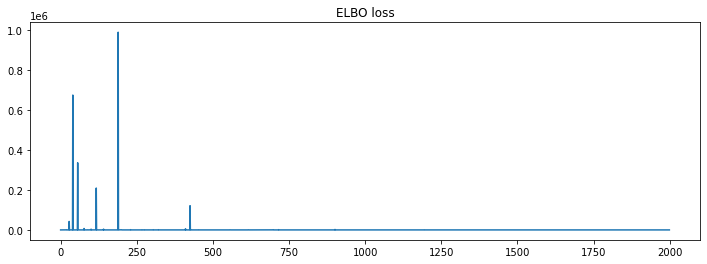

In [11]:
# do the training
pyro.set_rng_seed(0)
pyro.clear_param_store()
loss2plot=[]
for step in range(2000):
    loss = smoke_svi2.step(x2_train, y2_train)/len(x2_train)
    loss2plot.append(loss)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(loss2plot)
ax.set_title("ELBO loss");

In [12]:
# retrieve the fitted parameters
print("Inferred params:", list(pyro.get_param_store().keys()), end="\n\n")

inferred_w_a = pyro.get_param_store()["w_a_mean"]
inferred_w_b = pyro.get_param_store()["w_b_mean"]
inferred_b_a = pyro.get_param_store()["b_a_mean"]
inferred_b_b = pyro.get_param_store()["b_b_mean"]

for i,w in enumerate(inferred_w_a):
    print(f"w_a_{i} = {w.item():.8f}")
for i,w in enumerate(inferred_w_b):
    print(f"w_b_{i} = {w.item():.8f}")
print(f"b_a = {inferred_b_a.item():.8f}")
print(f"b_b = {inferred_b_b.item():.8f}")

# compute predictions using the inferred paramters
y2_pred = ((inferred_w_a * x2_test).sum(1) + inferred_b_a).exp()/ (((inferred_w_a * x2_test).sum(1) + inferred_b_a).exp() + ((inferred_w_b * x2_test).sum(1) + inferred_b_b).exp()) 

#compute MAE and MSE
print("MAE =", torch.nn.L1Loss()(y2_test, y2_pred).item())
print("MSE =", torch.nn.MSELoss()(y2_test, y2_pred).item())

#compute MAE and MSE using counts instead of ratios
y2_predcounts = torch.tensor(y2_pred.detach().numpy() * data["TotalCount"][indices[test_idx:]].values)
print("Adjusted MAE =", torch.nn.L1Loss()(y_test, y2_predcounts).item())
print("Adjusted MSE =", torch.nn.MSELoss()(y_test, y2_predcounts).item())

Inferred params: ['w_a_mean', 'w_a_stdev', 'w_b_mean', 'w_b_stdev', 'b_a_mean', 'b_a_stdev', 'b_b_mean', 'b_b_stdev']

w_a_0 = -0.50876814
w_a_1 = -0.02494177
w_a_2 = -0.33626473
w_a_3 = 0.00694238
w_a_4 = 0.44374740
w_a_5 = 0.31726277
w_a_6 = 0.55219877
w_a_7 = 0.76921266
w_a_8 = 1.00224197
w_a_9 = 0.67584944
w_a_10 = 0.04330673
w_b_0 = 1.24848533
w_b_1 = 1.21370900
w_b_2 = 0.63844424
w_b_3 = 0.49963924
w_b_4 = 0.62965506
w_b_5 = 0.11819734
w_b_6 = 0.02225317
w_b_7 = -0.06304298
w_b_8 = -0.36539257
w_b_9 = 0.58976007
w_b_10 = 0.18316692
b_a = -0.21863325
b_b = 0.75165528
MAE = 0.07353248447179794
MSE = 0.007215945981442928
Adjusted MAE = 100.7502280799672
Adjusted MSE = 16417.696901507163


Notice that the MAE and MSE had to be adjusted to be comparable with the first model's. This was done by simply  applying the predicted ratios to the corresponding samples' population counts.

As we can see by comparing the final scores, this second model performs much better than the first, and also the final metrics have a more intuitive explanation, since this time the MAE represents an average percentile rather than an absolute count.

## Exercise 2

The Iris dataset contains petal and sepal length and width for three different types of Iris flowers: Setosa, Versicolour, and Virginica.

1. Import the Iris dataset from `sklearn`:
```
from sklearn import datasets
iris = datasets.load_iris()
```
and perform a train-test split on the data.

2. Fit a multinomial bayesian logistic regression model on the four predictors petal length/width and sepal length/width. 

3. Evaluate your bayesian classifier on test data: compute the overall test accuracy and class-wise accuracy for the three different flower categories.

### Solution

First of all let's import the data and prepare it for the regression, that is, standardize it and perform the train/test split.

In [13]:
from sklearn import datasets

In [14]:
#import the iris dataset
iris = datasets.load_iris()

# standardize inputs
x = torch.tensor((iris.data - np.mean(iris.data,axis=0))/ np.std(iris.data,axis=0))
y = torch.tensor(iris.target)

# train/test 80/20 split
np.random.seed(77)
indices = np.random.permutation(x.shape[0])
test_idx = int(len(indices)*.8)
x_train, x_test = x[indices[:test_idx]], x[indices[test_idx:]]
y_train, y_test = y[indices[:test_idx]], y[indices[test_idx:]]

#check shapes
print("x_train.shape =", x_train.shape,"\ny_train.shape =", y_train.shape)
print("\nx_test.shape =", x_test.shape,"\ny_test.shape =", y_test.shape)

x_train.shape = torch.Size([120, 4]) 
y_train.shape = torch.Size([120])

x_test.shape = torch.Size([30, 4]) 
y_test.shape = torch.Size([30])


As requested in the exercise text, we will perform Bayesian regression using four regressors (Petal Length, Petal Width, Sepal Length, Sepal Width) to predict the flower type $y_i$, which is falls in one of three possible cathegories.

For this reason we will model $y_i$ using a Cathegorical distribution whose parameters will depend on the other covariates by means of a non-linear relation, that is, we will apply a softmax transform to the vector of linear combinations of the covariates. Furthermore, we'll assume normal priors for the weights and LogNormal prior for the biases. In symbols:

$$
y_i \sim \text{Categorical}(\pi_i)\\
\pi_i =\text{softmax}( (w_j \cdot x_i + b_j)_{j=0,1,2})\\
w_j \sim \mathcal{N}(\textbf{0},\textbf{1})\\
b_j \sim \text{LogNormal}(0,1)
$$

where

$$\text{softmax}(x_1,...,x_D) = \left(\frac{e^{x_d}}{\sum_{i=1}^D e^{x_i}}\right)_{d=1,...,D}$$

We thus define the outlined model and perform training

In [15]:
def model_cat(x, y):
    n, d = x.shape
    
    w0 = pyro.sample("w0", dist.Normal(torch.zeros(d), torch.ones(d)))
    b0 = pyro.sample("b0", dist.Normal(0.,1.))
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(d), torch.ones(d)))
    b1 = pyro.sample("b1", dist.Normal(0.,1.))
    w2 = pyro.sample("w2", dist.Normal(torch.zeros(d), torch.ones(d)))
    b2 = pyro.sample("b2", dist.Normal(0.,1.))
    
    probs = torch.softmax(torch.stack([(w0*x).sum(dim=1) + b0,
                                       (w1*x).sum(dim=1) + b1,
                                       (w2*x).sum(dim=1) + b2],
                                      dim=1),
                          dim=1)
    
    with pyro.plate("obs", n):
        pyro.sample("y", dist.Categorical(probs), obs=y)
        
def guide_cat(x, y=None):
    
    n, d = x.shape
    
    w0_mean = pyro.param("w0_mean", torch.rand(d))
    w0_std = pyro.param("w0_std", torch.rand(d), constraint=constraints.positive)
    w1_mean = pyro.param("w1_mean", torch.rand(d))
    w1_std = pyro.param("w1_std", torch.rand(d), constraint=constraints.positive)
    w2_mean = pyro.param("w2_mean", torch.rand(d))
    w2_std = pyro.param("w2_std", torch.rand(d), constraint=constraints.positive)
    
    w0 = pyro.sample("w0", dist.Normal(w0_mean, w0_std))
    w1 = pyro.sample("w1", dist.Normal(w1_mean, w1_std))
    w2 = pyro.sample("w2", dist.Normal(w2_mean, w2_std))
        
    b0_mean = pyro.param("b0_mean", torch.rand(1))
    b0_std = pyro.param("b0_std", torch.rand(1), constraint=constraints.positive)
    b1_mean = pyro.param("b1_mean", torch.rand(1))
    b1_std = pyro.param("b1_std", torch.rand(1), constraint=constraints.positive)
    b2_mean = pyro.param("b2_mean", torch.rand(1))
    b2_std = pyro.param("b2_std", torch.rand(1), constraint=constraints.positive)
    
    b0 = pyro.sample("b0", dist.Normal(b0_mean, b0_std))
    b1 = pyro.sample("b1", dist.Normal(b1_mean, b1_std))
    b2 = pyro.sample("b2", dist.Normal(b2_mean, b2_std))

iris_svi = SVI(model=model_cat, guide=guide_cat, 
              optim=optim.ClippedAdam({'lr' : 0.0002}), 
              loss=Trace_ELBO())

Step 0 : loss = 1.2714565412509178
Step 1000 : loss = 0.7431720755217232
Step 2000 : loss = 1.023967255005652
Step 3000 : loss = 0.8241319306727417
Step 4000 : loss = 0.5025882747259671
Step 5000 : loss = 0.48871074804910736
Step 6000 : loss = 0.43855192053554576
Step 7000 : loss = 0.4856206697275207
Step 8000 : loss = 0.42997610472818565
Step 9000 : loss = 0.4626948854572272
Step 10000 : loss = 0.39034618059654574
Step 11000 : loss = 0.3958409478751093
Step 12000 : loss = 0.3698604037800559
Step 13000 : loss = 0.3859813402682518
Step 14000 : loss = 0.44049000071146455
Step 15000 : loss = 0.3756974627202227


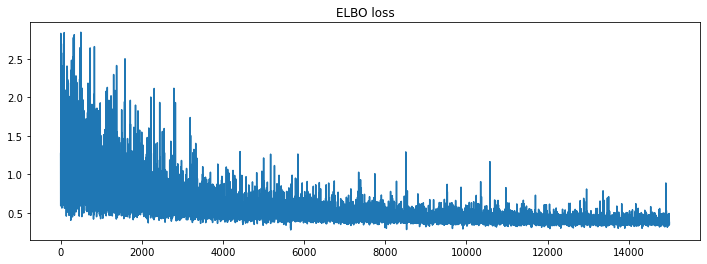

In [16]:
# do the training
pyro.set_rng_seed(777)
pyro.clear_param_store()
lossplot=[]
for step in range(15001):
    loss = iris_svi.step(x_train, y_train)/len(x_train)
    lossplot.append(loss)
    if step % 1000 == 0:
        print(f"Step {step} : loss = {loss}")

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(lossplot)
ax.set_title("ELBO loss");

The graph shows that the training did well, as it shows a neat convergence of the ELBO to a low value.  
Let's check the model total and class-wise accuracies, where

$$
\textit{Total Accuracy} = \frac{\textit{# Correct Guesses}}{ \textit{# Test Samples}}\\
\textit{K-Accuracy} = \frac{\textit{# Correct Guesses of class K}}{ \textit{# Test Samples of class K}}
$$

Furthermore our model outputs a probability vector on the classes. We use `argmax` to pick as predicted class the one with the highest score.

In [17]:
print("Inferred params:", list(pyro.get_param_store().keys()), end="\n\n")

Inferred params: ['w0_mean', 'w0_std', 'w1_mean', 'w1_std', 'w2_mean', 'w2_std', 'b0_mean', 'b0_std', 'b1_mean', 'b1_std', 'b2_mean', 'b2_std']



In [18]:
# get predicted params
w0 = pyro.get_param_store()["w0_mean"]
w1 = pyro.get_param_store()["w1_mean"]
w2 = pyro.get_param_store()["w2_mean"]
b0 = pyro.get_param_store()["b0_mean"]
b1 = pyro.get_param_store()["b1_mean"]
b2 = pyro.get_param_store()["b2_mean"]

# define class predicting function
def predict(x):
    probs = torch.softmax(torch.stack([(w0*x).sum(dim=1) + b0,
                                       (w1*x).sum(dim=1) + b1,
                                       (w2*x).sum(dim=1) + b2],
                                      dim=1),
                          dim=1)
    return torch.argmax(probs,dim=1)

#compute test and class-wise accuracies
y_pred = predict(x_test)
print(f"test accuracy = {(y_test == y_pred).sum().item() / len(y_test)*100:.2f}% [{(y_test == y_pred).sum().item()}/{len(y_test)}]")
for i in range(3):
    print(f"class {i} accuracy = {(y_test[y_test==i] == y_pred[y_test==i]).sum().item() / len(y_test[y_test==i])*100:.2f}% [{(y_test[y_test==i] == y_pred[y_test==i]).sum().item()}/{len(y_test[y_test==i])}]")

test accuracy = 100.00% [30/30]
class 0 accuracy = 100.00% [10/10]
class 1 accuracy = 100.00% [9/9]
class 2 accuracy = 100.00% [11/11]


The model performed flawlessly, thus confirming our optimistic interpretation of the training loss graph.  

Thank you dear `iris` dataset for giving us such satisfactions, I guess that's the secret behind your being such an all-time favourite. It's a real pity, though, that real world data doesn't behave well like you.